# **Overview of the EHR Retrieval System**

This code demonstrates the process of **retrieving relevant treatment records** from a dataset of patient medical records, based on a set of user-defined queries. It uses **semantic search** techniques to match the query with relevant records, allowing for more flexible and meaningful comparisons rather than relying on exact text matching. Here’s how the system works:

### **1. Loading Multiple Datasets**
The code begins by processing multiple **JSON dataset files** (`1.json`, `2.json`, `3.json`), each representing a collection of medical records. The datasets contain patient treatment history, which is used for further analysis.

### **2. Preprocessing the Data**
For each dataset:
- The data is **cleaned** using the `_clean_text` method, which removes sensitive information like patient names or IDs.
- The text is then **split into sections** based on common section headers like “Plan”, “Treatment”, and “Assessment”.
- Relevant sections are identified based on the presence of **radiation treatment terms** (e.g., "radiation", "chemotherapy", "EBRT").
- The method checks if the treatments are from the **past**, by comparing treatment dates with a **hardcoded current date**.

### **3. Defining Queries**
The system works with predefined **queries** related to cancer treatments and follow-up care. These queries include questions like:
- "Was chemotherapy administered?"
- "Did the patient undergo surgery?"
- "What follow-up imaging or lab tests were planned?"

These queries are intended to extract information from the preprocessed treatment records.

### **4. Retrieving Relevant Treatment Records**
For each query:
- The **treatment records** are encoded using a **SentenceTransformer model**, which converts both the query and treatment records into **vector representations**.
- **Cosine similarity** is then calculated between the query and the treatment records to measure how similar each record is to the query.
- The top `N` most relevant records are selected based on their similarity scores.

### **5. Displaying Results**
The system retrieves and **displays the top matching treatment records** for each query, sorted by their relevance. For each result, it shows:
- The treatment record and its similarity score.
- The results are sorted in descending order of relevance, with the most relevant treatments displayed first.

### **Why This Approach?**
This method allows for **semantic matching** of patient records with queries, ensuring that the system finds the most relevant treatment records even if the phrasing differs. It’s particularly useful in healthcare settings where medical terms and treatments are varied, and the system needs to understand the meaning rather than relying on exact keyword matches.

### **Summary**
This code processes and searches medical records based on specific treatment-related queries, allowing healthcare professionals to quickly retrieve the most relevant patient information. It utilizes natural language processing and machine learning to **automatically identify** treatments, assess their relevance, and display the results, all while respecting patient privacy by cleaning sensitive data.


## Core Dependencies
- **json**: Handles reading/writing of JSON-formatted EHR data
- **re**: Performs regex pattern matching for text cleaning
- **numpy**: Enables numerical operations for similarity scoring
- **datetime**: Manages temporal filtering of medical records
- **SentenceTransformer**: Powers semantic text embeddings (using 'paraphrase-MiniLM-L6-v2' model)
- **cosine_similarity**: Computes similarity between query and document embeddings

In [51]:
import json
import re
import numpy as np
from datetime import datetime
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## EHR Retrieval System Setup
- **patient_data**: Stores loaded JSON medical records
- **model**: Initializes lightweight sentence embedding model (80MB)
- **chunks**: Holds preprocessed text segments
- **current_date**: Simulated future date (2026-01-01) for testing temporal filters
- **Purpose**: Creates framework for handling oncology EHR data analysis

In [52]:
class EHRRetrievalSystem:
    def __init__(self, patient_data):
        self.patient_data = patient_data  # Store patient data passed during initialization
        self.model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Load the pre-trained SentenceTransformer model for sentence embeddings
        self.chunks = []  # Initialize an empty list to store the processed chunks of relevant treatment information
        # Simulate current date as 2026 for testing
        self.current_date = datetime(2026, 1, 1)  # Use a future date for testing purposes (hardcoded date for date comparison)


## Protected Health Information (PHI) Redaction
- Removes sensitive patient identifiers using regex patterns:
  - Patient Name
  - Medical Record Number (MRN)
  - Location data
- Preserves clinical content while maintaining HIPAA compliance
- Operates case-insensitively to catch variations

In [53]:
def _clean_text(self, text):
    """Lightweight PHI removal"""
    # Remove sensitive patient information like name, MRN, and location from the text
    return re.sub(r'(Patient Name|MRN|Location):.*?\n', '', text, flags=re.IGNORECASE)

EHRRetrievalSystem._clean_text = _clean_text  # Attach the _clean_text method to the EHRRetrievalSystem class


## Date Validation System
- Handles multiple date formats (MM-DD-YYYY and MM/DD/YYYY)
- Converts string dates to datetime objects for comparison
- Returns True if treatment occurred before simulated current date (2026)
- Error-tolerant design skips malformed dates

In [54]:
def _is_past_treatment(self, chunk_text):
    """Robust date parsing for MM-DD-YYYY and MM/DD/YYYY"""
    date_formats = [r'\d{2}-\d{2}-\d{4}', r'\d{2}/\d{2}/\d{4}']  # Define date formats for both MM-DD-YYYY and MM/DD/YYYY
    for fmt in date_formats:
        match = re.search(fmt, chunk_text)  # Search for a date match in the chunk text
        if match:
            date_str = match.group()  # Extract the matched date string
            try:
                # Parse the date string to a datetime object based on the format
                date_obj = datetime.strptime(date_str, '%m-%d-%Y' if '-' in date_str else '%m/%d/%Y')
                # Check if the parsed date is earlier than the current date
                return date_obj.date() < self.current_date.date()
            except:
                continue  # In case of error, skip to next format
    return False  # Return False if no valid past date is found

EHRRetrievalSystem._is_past_treatment = _is_past_treatment  # Attach the _is_past_treatment method to the EHRRetrievalSystem class


## Radiation Therapy Identifier
- Regex pattern matches radiation-specific terms:
  - Radiation/radiotherapy
  - Brachytherapy/EBRT/XRT
  - Advanced techniques (proton therapy, stereotactic)
- Case-insensitive search (re.I flag)
- Covers both technical and colloquial treatment names

In [55]:
def _contains_treatment(self, text):
    """Check for radiation-related treatments"""
    # Use regex to search for radiation-related terms in the provided text (case-insensitive)
    return re.search(
        r'\b(radiation|radiotherapy|brachytherapy|EBRT|XRT|external beam|seed implant|proton therapy|stereotactic)\b', 
        text, re.I  # 're.I' makes the search case-insensitive
    )

EHRRetrievalSystem._contains_treatment = _contains_treatment  # Attach the _contains_treatment method to the EHRRetrievalSystem class


## Clinical Text Processing Pipeline
1. Cleans PHI from raw EHR text
2. Splits documents into clinical sections using headers:
   - Plan
   - Treatment
   - Imaging Findings
   - Assessment
   - Conclusion
3. Combines header + content for context preservation
4. Filters sections containing radiation treatments
5. Validates treatment dates against temporal constraints

In [56]:
def preprocess(self):
    """Extract and preprocess relevant treatment data"""
    for doc in self.patient_data:
        cleaned = self._clean_text(doc['docText'])  # Clean text to remove sensitive information
        date_str = doc['docDate'].replace('-', '/')  # Replace dashes with slashes in the date string for consistency
        
        # Split the cleaned text into sections based on common headers like 'Plan:', 'Treatment:', etc.
        sections = re.split(r'\n\s*(Plan:|Treatment:|Imaging Findings:|Assessment:|Conclusion:)', cleaned)
        
        # Iterate through the sections to find treatment-related content
        for i in range(1, len(sections), 2):
            section = sections[i] + sections[i+1]  # Combine the section header with the content
            if self._contains_treatment(section) and len(section) > 30:  # Check if treatment-related info is found and the section is long enough
                chunk = f"{doc['docTitle']} ({date_str}): {section.strip()}"  # Format the chunk with document title and date
                if self._is_past_treatment(chunk):  # Check if the treatment date is in the past
                    self.chunks.append(chunk)  # Add the relevant chunk to the list of chunks

EHRRetrievalSystem.preprocess = preprocess  # Attach the preprocess method to the EHRRetrievalSystem class

## Neural Information Retrieval
1. Encodes text chunks into 384-dim vectors
2. Computes query embedding using same model
3. Calculates cosine similarity scores
4. Selects top 3 most relevant matches
5. Returns results with confidence scores (0-1 scale)
- Uses batch processing for memory efficiency

In [57]:
def retrieve(self, query, top_n=3):
    """Retrieve most relevant treatment records"""
    if not self.chunks:
        return []  # If no chunks are available, return an empty list
    
    # Encode the chunks (treatment records) and the query into embeddings (numerical representations)
    chunk_embs = self.model.encode(self.chunks, batch_size=16, convert_to_numpy=True)  # Encode all treatment chunks
    query_emb = self.model.encode(query)  # Encode the query into an embedding
    
    # Compute cosine similarity between the query embedding and the chunk embeddings
    scores = cosine_similarity([query_emb], chunk_embs)[0]  # Calculate similarity scores for each chunk
    
    # Find the indices of the top_n most similar chunks
    top_indices = np.argpartition(scores, -top_n)[-top_n:]  # Get the indices of the top_n relevant chunks
    
    # Return the top_n most relevant treatment records along with their similarity scores
    return [(self.chunks[i], scores[i]) for i in top_indices]

EHRRetrievalSystem.retrieve = retrieve  # Attach the retrieve method to the EHRRetrievalSystem class



## Multi-Dataset Analysis Process
- Processes 3 cancer datasets sequentially:
  1. Breast cancer (1.json)
  2. Lung cancer (2.json)
  3. Prostate cancer (3.json)
  
- Runs 5 clinical queries per dataset:
  1. Treatment options by stage
  2. Chemotherapy administration
  3. Recurrence monitoring
  4. Surgical history
  5. Specific AC chemo verification
  
- Outputs ranked results with similarity scores

In [70]:
# List of dataset files
dataset_files = ['1.json','2.json','3.json']

# List of queries
queries = [
    "What were the recommended treatment options based on the patient’s cancer stage and pathology?",
    "Was chemotherapy administered?",
    "What follow-up imaging or lab tests were planned to monitor for recurrence?",
    "Did the patient undergo surgery?",
    "Has the patient undergone AC chemotherapy?"
]

# Store results for plotting
query_results = {query: {file: [] for file in dataset_files} for query in queries}

# Process each dataset separately
for file in dataset_files:
    print(f"\nProcessing Dataset: {file}\n" + "-"*50)  # Print dataset file name and separator
    
    # Load the dataset from the JSON file
    with open(file, encoding="utf-8") as f:
        patient_data = json.load(f)  # Load patient data from the JSON file

    # Create an instance of the EHR retrieval system with the patient data
    ehr_system = EHRRetrievalSystem(patient_data)
    
    # Preprocess the data (clean text, extract relevant treatment sections, etc.)
    ehr_system.preprocess()

    # Iterate over each query
    for query_num, query in enumerate(queries, 1):
        results = ehr_system.retrieve(query)  # Retrieve most relevant treatment records for the current query
        
        # Store the top similarity score for the query and dataset
        if results:
            top_score = results[0][1]  # Get the score of the most relevant chunk
            query_results[query][file].append(top_score)
        else:
            query_results[query][file].append(0)  # In case no results were found
        
        # Print query and results
        print(f"\nQuery {query_num}: {query}")
        print("Most Relevant Treatment Records:")
        
        # Sort the results by score in descending order and print the top results
        for i, (chunk, score) in enumerate(sorted(results, key=lambda x: -x[1]), 1):
            print(f"{i}. [{score:.2f}] {chunk}\n")  # Print the chunk and its similarity score


Processing Dataset: 1.json
--------------------------------------------------

Query 1: What were the recommended treatment options based on the patient’s cancer stage and pathology?
Most Relevant Treatment Records:
1. [0.58] Medical Oncology Consultation – Adjuvant Therapy Planning (02/26/2020): Assessment:
Given her receptor profile, she is a candidate for combined chemotherapy and HER2-targeted therapy (e.g., trastuzumab). She also qualifies for hormonal therapy (an aromatase inhibitor or tamoxifen) after the completion of chemotherapy, due to her ER/PR positivity.

Proposed Treatment Plan:
1. **Chemotherapy Regimen**: A regimen such as doxorubicin and cyclophosphamide (AC) for 4 cycles, followed by paclitaxel (T) weekly for 12 weeks, is a standard approach. 
2. **HER2-Targeted Therapy**: Trastuzumab (and possibly pertuzumab) can be started concurrently with the taxane portion of chemotherapy and continued for a total of 12 months (adjuvant setting). Cardiac function monitoring (ec

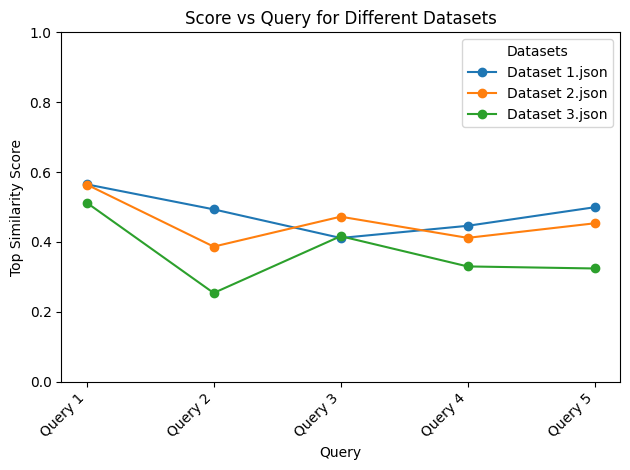

In [71]:
# Prepare data for plotting (scores across queries for each dataset)
for file in dataset_files:
    scores = [query_results[query][file][0] for query in queries]  # Get top score for each query
    plt.plot([f'Query {i+1}' for i in range(len(queries))], scores, marker='o', label=f'Dataset {file}')

# Add labels and title
plt.title('Score vs Query for Different Datasets')
plt.xlabel('Query')
plt.ylabel('Top Similarity Score')
plt.xticks(rotation=45, ha='right')  # Rotate query labels for better readability
plt.ylim(0, 1)  # Assuming similarity scores are between 0 and 1
plt.legend(title="Datasets")
plt.tight_layout()  # Adjust layout for better spacing

# Display the graph
plt.show()

### Explanation for Plotting the Graph:

This plot shows how well the retrieval system performs across different queries and datasets. Here's a simplified breakdown:

1. **Data Representation**:
   - The plot compares the top similarity scores for each query across multiple datasets.
   - A higher score means the dataset's treatment record is more relevant to the query.

2. **Structure of the Plot**:
   - The x-axis represents the queries (labeled as `Query 1`, `Query 2`, etc.) for simplicity.
   - The y-axis shows the similarity score, which ranges from 0 (no relevance) to 1 (perfect relevance).

3. **Dataset Comparison**:
   - Each dataset is represented by a line, and its top similarity score for each query is plotted.
   - The legend shows which line corresponds to each dataset.

4. **Plot Styling**:
   - Query labels on the x-axis are rotated for better readability.
   - The y-axis is set from 0 to 1, assuming scores fall within this range.
   - A tight layout ensures the plot fits well on the screen.

5. **Insights**:
   - This graph allows easy comparison of how well each dataset matches the queries. If a dataset consistently scores higher, it’s more relevant to the queries.
   - The plot helps assess how well the system works with each dataset.

6. **Model Performance**:
   - The graph also shows how our model performed across different datasets for various queries, helping to evaluate its overall effectiveness.

In short, this graph provides a visual way to understand how different datasets perform in response to specific queries.
